# Data Analyst Nanodegree
# Project 4 - Wrangling and Analyze Data
## Part I: Data Wrangling

In [1]:
# Import all necessary libraries
import requests
import os
import tweepy
import json
import re
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
%matplotlib inline

## Gather

### Twitter archive
#### Load local file

In [2]:
# Check if file exists in directory, read into dataframe
fname = 'twitter-archive-enhanced.csv'
if os.path.exists(fname) :
    print('File found. Bytes:', os.stat(fname).st_size)
    df1 = pd.read_csv(fname)
else : print('File not found.')

File found. Bytes: 915692


### Tweet image predictions
#### Download a file

In [3]:
# Request a file and write to disk
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/'
fname = 'image-predictions.tsv'
r = requests.get(url+fname)

with open(fname, 'wb') as f :
    f.write(r.content)

In [4]:
# Test the file
print('Bytes on the server:', r.headers['Content-length'], '\tBytes on disk:', os.stat(fname).st_size)
print('Same length?\t', int(r.headers['Content-length']) == os.stat(fname).st_size)

Bytes on the server: 335079 	Bytes on disk: 335079
Same length?	 True


### Tweet retweets, favorites, etc.
#### Query Twitter API

In [5]:
# Assess tweet ID's format
df1.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


In [6]:
df1.tweet_id.dtype

dtype('int64')

In [7]:
while True :
    skipq = input(('(C)onnect to Twitter API or (S)kip?\nConnect only if valid API keys are provided below.\n'))
    if skipq.lower() == 's' :
        skip = True
        print('Skipping.')
        break
    elif skipq.lower() == 'c' :
        skip = False
        print('Connecting to Twitter API')
        break
    else :
        print('Wrong input, try again.')
        continue

(C)onnect to Twitter API or (S)kip?
Connect only if valid API keys are provided below.
c
Connecting to Twitter API


In [8]:
# API authorisation - use own keys
while True :
    if skip : break
    consumer_key = ''
    consumer_secret = ''
    access_token = ''
    access_secret = ''

    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)

    api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
    break

In [9]:
# Test connection
while True :
    if skip : break
    tweet = api.get_status(df1.tweet_id[0], tweet_mode='extended')
    print(tweet.full_text)
    break

This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU


In [10]:
# Parse tweet's JSON to preview structure
while True :
    if skip : break
    json_str = json.dumps(tweet._json, ensure_ascii=False)
    json_parsed = json.loads(json_str)

    print(json.dumps(json_parsed, indent=4))
    break

{
    "created_at": "Tue Aug 01 16:23:56 +0000 2017",
    "id": 892420643555336193,
    "id_str": "892420643555336193",
    "full_text": "This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU",
    "truncated": false,
    "display_text_range": [
        0,
        85
    ],
    "entities": {
        "hashtags": [],
        "symbols": [],
        "user_mentions": [],
        "urls": [],
        "media": [
            {
                "id": 892420639486877696,
                "id_str": "892420639486877696",
                "indices": [
                    86,
                    109
                ],
                "media_url": "http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg",
                "media_url_https": "https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg",
                "url": "https://t.co/MgUWQ76dJU",
                "display_url": "pic.twitter.com/MgUWQ76dJU",
                "expanded_url": "https://twitter.com/dog_rat

In [11]:
# Checking if file exists, deleting as per user decision or skipping API part altogether.
fname = 'tweet_json.txt'

while True :
    if skip : break
    if os.path.exists(fname) :
        print('Previous file found. Bytes:', os.stat(fname).st_size)
        delq = input(('Delete and generate (N)ew from API\n(A)ppend lines to existing\n(S)kip API part\n'))
        if delq.lower() == 'n' :
            os.remove(fname)
            print('File deleted. Will write to blank file.')
        elif delq.lower() == 'a' : print('File kept. Writing lines to existing file.')
        elif delq.lower() == 's' :
            print('Skipping API querying. Will use existing file.')
            skip = True
        else : print('Unrecognized input')
    else : print('File not found. Will write to blank file.')
    
    # Break from the loop, skipping API querying
    if skip : break

    # Looping through tweets, writing JSON to file.
    count = 0
    nf_count = 0
    if os.path.exists('tweets_not_found.txt') : os.remove('tweets_not_found.txt')
    for twid in df1.tweet_id :
        count += 1
        if count % 100 == 0 : print('Processing tweet no.', count)
        try :
            tweet = api.get_status(twid, tweet_mode='extended')
            json_str = json.dumps(tweet._json, ensure_ascii=False)
            with open(fname, 'ab') as f :
                f.write((json_str+'\n').encode())
        except :
            nf_count += 1
            # turning this off - too many alerts.
            # print('Tweet', twid, 'not found. Skipping to next.')
            with open('tweets_not_found.txt', 'a') as f :
                f.write(str(twid)+'\n')
            continue

    print('Work finished. \nTweets checked:', count, '\tTweets written:', count-nf_count, '\tTweets not found:', nf_count)
    print('Not found tweet id\'s written to file: tweets_not_found.txt')
    break

Previous file found. Bytes: 852786
Delete and generate (N)ew from API
(A)ppend lines to existing
(S)kip API part
n
File deleted. Will write to blank file.
Processing tweet no. 100
Processing tweet no. 200
Processing tweet no. 300
Processing tweet no. 400
Processing tweet no. 500
Processing tweet no. 600
Processing tweet no. 700


Rate limit reached. Sleeping for: 118


Processing tweet no. 800
Processing tweet no. 900
Processing tweet no. 1000
Processing tweet no. 1100
Processing tweet no. 1200
Processing tweet no. 1300
Processing tweet no. 1400
Processing tweet no. 1500
Processing tweet no. 1600


Rate limit reached. Sleeping for: 529


Processing tweet no. 1700
Processing tweet no. 1800
Processing tweet no. 1900
Processing tweet no. 2000
Processing tweet no. 2100
Processing tweet no. 2200
Processing tweet no. 2300
Work finished. 
Tweets checked: 2356 	Tweets written: 2331 	Tweets not found: 25
Not found tweet id's written to file: tweets_not_found.txt


### Read into dataframes

In [12]:
# Twitter archive-enhanced.csv is already loaded as df1
# Reading image predictions into a second df
df_img = pd.read_csv('image-predictions.tsv', sep='\s', engine='python')

In [13]:
# Twitter API data - building a list of dicts
data = list()
with open(fname, encoding='utf-8') as f :
    for line in f :
        json_str = json.loads(line)
        data.append({'tweet_id':json_str['id'], 'likes':json_str['favorite_count'], 'retweets':json_str['retweet_count']})

# Commenting out below - not essential, notworking if skipped using API
# if len(data) == count - nf_count : print('List of dicts successfully created.')
# else : print('Something went wrong.', len(data), 'dicts created. Should be', count - nf_count)

In [14]:
# Twitter API data - building a df
df_api = pd.DataFrame(data)

## Assess

In [15]:
df1.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [17]:
df1.tweet_id.duplicated().sum()

0

In [18]:
# Investigate questionable columns
cols_check = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
                 'retweeted_status_timestamp', 'doggo', 'floofer', 'pupper', 'puppo']

df1[cols_check].nunique()

in_reply_to_status_id          77
in_reply_to_user_id            31
retweeted_status_id           181
retweeted_status_user_id       25
retweeted_status_timestamp    181
doggo                           2
floofer                         2
pupper                          2
puppo                           2
dtype: int64

In [19]:
# Check values in float64 columns
df1[cols_check[0]].unique()[:10]

array([           nan, 8.86266357e+17, 8.81607037e+17, 8.79553827e+17,
       8.70726203e+17, 8.63425646e+17, 6.67152164e+17, 8.57156678e+17,
       8.55818117e+17, 8.56286004e+17])

In [20]:
df1[cols_check[1]].unique()[:10]

array([           nan, 2.28118160e+09, 4.73844300e+07, 3.10544075e+09,
       1.64877600e+07, 7.75962000e+07, 4.19698384e+09, 1.80670967e+08,
       2.79280991e+08, 1.94351775e+08])

In [21]:
df1[cols_check[2]].unique()[:10]

array([           nan, 8.87473957e+17, 8.86053734e+17, 8.30583321e+17,
       8.78057613e+17, 8.78281511e+17, 6.69000397e+17, 8.76850772e+17,
       8.66334965e+17, 8.68880398e+17])

In [22]:
df1[cols_check[3]].unique()[:10]

array([           nan, 4.19698384e+09, 1.96074000e+07, 5.12804507e+08,
       1.54767397e+08, 7.87461778e+17, 3.63890752e+08, 5.87097230e+07,
       6.66990130e+07, 7.47554344e+17])

In [23]:
df1[cols_check[4]].unique()[:10]

array([nan, '2017-07-19 00:47:34 +0000', '2017-07-15 02:44:07 +0000',
       '2017-02-12 01:04:29 +0000', '2017-06-23 01:10:23 +0000',
       '2017-06-23 16:00:04 +0000', '2015-11-24 03:51:38 +0000',
       '2017-06-19 17:14:49 +0000', '2017-05-21 16:48:45 +0000',
       '2017-05-28 17:23:24 +0000'], dtype=object)

In [24]:
df1['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [25]:
stage = ['doggo', 'floofer', 'pupper', 'puppo']
for s in stage :
    print(df1[s].value_counts())

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


In [26]:
df1['name'].value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
          ... 
Harnold      1
Kulet        1
Goliath      1
Chloe        1
Champ        1
Name: name, Length: 957, dtype: int64

In [27]:
df1['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
0         2
15        2
75        2
420       2
182       1
204       1
143       1
121       1
99        1
20        1
45        1
27        1
17        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
1776      1
960       1
666       1
144       1
165       1
Name: rating_numerator, dtype: int64

In [28]:
df1['rating_denominator'].value_counts()

10     2333
11        3
50        3
20        2
80        2
0         1
120       1
7         1
170       1
150       1
130       1
90        1
110       1
2         1
70        1
40        1
16        1
15        1
Name: rating_denominator, dtype: int64

In [29]:
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [30]:
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [31]:
df_img.tweet_id.duplicated().sum()

0

In [32]:
df_img.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
lynx                    1
ocarina                 1
traffic_light           1
swab                    1
ping-pong_ball          1
Name: p1, Length: 378, dtype: int64

In [33]:
# Holy cow! Quite a soup.
df_img.p1.unique()[:30]

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher',
       'Bernese_mountain_dog', 'box_turtle', 'chow', 'shopping_cart',
       'miniature_poodle', 'golden_retriever', 'Gordon_setter',
       'Walker_hound', 'pug', 'bloodhound', 'Lhasa', 'English_setter',
       'hen', 'desktop_computer', 'Italian_greyhound', 'Maltese_dog',
       'three-toed_sloth', 'ox', 'malamute', 'guinea_pig',
       'soft-coated_wheaten_terrier', 'Chihuahua',
       'black-and-tan_coonhound', 'coho', 'toy_terrier'], dtype=object)

In [34]:
df_img.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
dumbbell                1
bucket                  1
red_fox                 1
bagel                   1
tiger                   1
Name: p2, Length: 405, dtype: int64

In [35]:
df_img.p2.unique()[:30]

array(['collie', 'miniature_pinscher', 'malinois', 'redbone',
       'Rottweiler', 'English_springer', 'mud_turtle', 'Tibetan_mastiff',
       'shopping_basket', 'komondor', 'Yorkshire_terrier',
       'English_foxhound', 'bull_mastiff', 'German_shepherd', 'Shih-Tzu',
       'Newfoundland', 'cock', 'desk', 'toy_terrier', 'toy_poodle',
       'otter', 'Chesapeake_Bay_retriever', 'Siberian_husky', 'skunk',
       'Afghan_hound', 'bloodhound', 'barracouta', 'papillon',
       'cocker_spaniel', 'chow'], dtype=object)

In [36]:
df_img.p3.value_counts()

Labrador_retriever    79
Chihuahua             58
golden_retriever      48
Eskimo_dog            38
kelpie                35
                      ..
hare                   1
can_opener             1
partridge              1
park_bench             1
cliff                  1
Name: p3, Length: 408, dtype: int64

In [37]:
df_img.p3.unique()[:30]

array(['Shetland_sheepdog', 'Rhodesian_ridgeback', 'bloodhound',
       'miniature_pinscher', 'Doberman', 'Greater_Swiss_Mountain_dog',
       'terrapin', 'fur_coat', 'golden_retriever',
       'soft-coated_wheaten_terrier', 'Labrador_retriever', 'Pekinese',
       'Ibizan_hound', 'French_bulldog', 'malinois', 'Dandie_Dinmont',
       'borzoi', 'partridge', 'bookcase', 'basenji', 'miniature_poodle',
       'great_grey_owl', 'groenendael', 'Eskimo_dog', 'hamster', 'briard',
       'papillon', 'flat-coated_retriever', 'gar', 'Chihuahua'],
      dtype=object)

In [38]:
# Check for duplicates across columns
for col in df_img :
    if df_img[col].duplicated().sum() > 0 :
        print(col, df_img[col].duplicated().sum())

jpg_url 66
img_num 2071
p1 1697
p1_conf 69
p1_dog 2073
p2 1670
p2_conf 71
p2_dog 2073
p3 1667
p3_conf 69
p3_dog 2073


In [39]:
df_api.head()

,tweet_id,likes,retweets
0,892420643555336193,34943,7331
1,892177421306343426,30258,5473
2,891815181378084864,22766,3620
3,891689557279858688,38207,7521
4,891327558926688256,36476,8091


In [40]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   tweet_id  2331 non-null   int64
 1   likes     2331 non-null   int64
 2   retweets  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [41]:
df_api.tweet_id.duplicated().sum()

0

In [42]:
# Check if full data is available for tweets with photos
assert df_img.tweet_id.isin(df1.tweet_id).sum() == df_img.shape[0]

### Issues
#### Tidiness
- Would be clearer to have separate tables for **tweets**, **dogs** and **images**.
- Four variables of 'dog stage' in one column: `doggo`, `floofer`, `pupper`, `puppo`.

#### Quality
**`df1` - twitter-archive-enhanced.csv**
- Image predictions data not available for all tweets from this initial dataset.
- Some tweets ~~may be~~ are retweets.
- Four ID columns are of float64 type, not integer: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`.
- Two timestamp columns are of object / string type, not date/time: `timestamp`, `retweeted_status_timestamp`.
- `source` column contains irrelevant urls within HTML tags. (Possibly) more useful urls are in the `expanded_urls` column.
- 'Dog stage' is of type string instead of category.
- Not all dogs have 'dog stage' data.
- Some records have more than one 'dog stage' assigned.
- Not all dogs have `name` value.
- Part of `rating_numerator` values are out of convention, ie. not the typical 10 to 14.
- Part of `rating_denominator` values are out of convention, ie. not 10.

**`df_img` - image-predictions.tsv**
- Duplicated `jpg_url` values
- `p1`, `p2` and `p3` have inconsistent letter case formatting.

**`df_api` - tweet_json.txt**
- Data not available for all tweets from initial data set. -- tweets were deleted, unable to recover data, will not touch this

## Clean

In [43]:
# Make copies of df's
df1_c = df1.copy()
df_img_c = df_img.copy()
df_api_c = df_api.copy()

### Possible retweets
#### Prerequisite: Four ID columns are of float64 type, not integer: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`.

#### Define
Convert ID columns' data type to (nullable) integer.

#### Code

In [44]:
df1_c = df1_c.astype({'in_reply_to_status_id':'Int64', 'in_reply_to_user_id':'Int64',
                      'retweeted_status_id':'Int64', 'retweeted_status_user_id':'Int64'});

#### Test

In [45]:
df1_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   tweet_id                    2356 non-null   int64 
 1   in_reply_to_status_id       78 non-null     Int64 
 2   in_reply_to_user_id         78 non-null     Int64 
 3   timestamp                   2356 non-null   object
 4   source                      2356 non-null   object
 5   text                        2356 non-null   object
 6   retweeted_status_id         181 non-null    Int64 
 7   retweeted_status_user_id    181 non-null    Int64 
 8   retweeted_status_timestamp  181 non-null    object
 9   expanded_urls               2297 non-null   object
 10  rating_numerator            2356 non-null   int64 
 11  rating_denominator          2356 non-null   int64 
 12  name                        2356 non-null   object
 13  doggo                       2356 non-null   obje

#### Check if any tweets in the initial dataset are retweets.

#### Assess

In [46]:
df1_c['in_reply_to_status_id'].isin(df1_c.tweet_id).sum()

33

In [47]:
df1_c['retweeted_status_id'].isin(df1_c.tweet_id).sum()

112

145 tweets in the initial data set are either replies or retweets.

In [48]:
# Preview original tweets
df1_c.query('tweet_id in in_reply_to_status_id').head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
192,855818117272018944,<NA>,<NA>,2017-04-22 16:18:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I HEARD HE TIED HIS OWN BOWTIE MARK AND HE JUS...,<NA>,<NA>,NaN,https://twitter.com/markhalperin/status/855656...,13,10,None,None,None,None,None
229,848212111729840128,<NA>,<NA>,2017-04-01 16:35:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jerry. He's doing a distinguished tong...,<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/848212111...,6,10,Jerry,None,None,None,None
499,813127251579564032,<NA>,<NA>,2016-12-25 21:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's an anonymous doggo that appears to be v...,<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/813127251...,11,10,None,doggo,None,None,None


In [49]:
# Preview replies
df1_c.query('in_reply_to_status_id in tweet_id').head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
184,856526610513747968,855818117272018944,4196983835,2017-04-24 15:13:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...","THIS IS CHARLIE, MARK. HE DID JUST WANT TO SAY...",<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/856526610...,14,10,None,None,None,None,None
228,848213670039564288,848212111729840128,4196983835,2017-04-01 16:41:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Jerry just apuppologized to me. He said there ...,<NA>,<NA>,NaN,NaN,11,10,None,None,None,None,None
251,844979544864018432,759099523532779520,4196983835,2017-03-23 18:29:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",PUPDATE: I'm proud to announce that Toby is 23...,<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/844979544...,13,10,None,None,None,None,None


In [50]:
# Preview original tweets
df1_c.query('tweet_id in retweeted_status_id').head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
75,878281511006478336,<NA>,<NA>,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Shadow. In an attempt to reach maximum zo...,<NA>,<NA>,NaN,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
76,878057613040115712,<NA>,<NA>,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Emmy. She was adopted today. Massive r...,<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
98,873213775632977920,<NA>,<NA>,2017-06-09 16:22:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sierra. She's one precious pupper. Abs...,<NA>,<NA>,NaN,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [51]:
# Preview retweets
df1_c.query('retweeted_status_id in tweet_id').head(3)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
36,885311592912609280,<NA>,<NA>,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,830583320585068544,4196983835,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,<NA>,<NA>,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,878057613040115712,4196983835,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,<NA>,<NA>,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,878281511006478336,4196983835,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None


#### Define
Remove retweets and replies that are responses to original tweets, since _"You only want original ratings (no retweets) that have images."_

#### Code

In [52]:
df1_c = df1_c.query('(in_reply_to_status_id not in tweet_id) & (retweeted_status_id not in tweet_id)')

#### Test

In [53]:
assert df1_c['in_reply_to_status_id'].isin(df1_c.tweet_id).sum() + df1_c['retweeted_status_id'].isin(df1_c.tweet_id).sum() == 0

In [54]:
df1_c.shape[0]

2211

### Records with no image data

#### Image predictions data not available for all tweets from this initial dataset.
#### Define

Drop records where there is no image prediction data AND drop image prediction data where there is no corresponding tweet data.

#### Code

In [55]:
df1_c = df1_c.query('tweet_id in @df_img_c.tweet_id')
df_img_c = df_img_c.query('tweet_id in @df1_c.tweet_id')

#### Test

In [56]:
assert df1_c['tweet_id'].count() == df_img_c['tweet_id'].count() == df_img_c['tweet_id'].isin(df1_c['tweet_id']).sum()

In [57]:
# There are now fewer jpg_url duplicates in image data frame, but some still remain
for col in df_img_c :
    if df_img_c[col].duplicated().sum() > 0 :
        print(col, df_img_c[col].duplicated().sum())

jpg_url 19
img_num 2008
p1 1634
p1_conf 22
p1_dog 2010
p2 1611
p2_conf 24
p2_dog 2010
p3 1604
p3_conf 22
p3_dog 2010


### Tidiness - part 1
#### Four variables of 'dog stage' in one column: `doggo`, `floofer`, `pupper`, `puppo`. 
**Additional issue: some records have more than one 'dog stage' assigned.**
#### Description

Replace four columns with 'dog stages' with one categorical column `stage`

#### Code

In [58]:
cols_stages = list(df1_c.columns[-4:])

# Extracting more dog stage data from 'text' column
for col in cols_stages :
    df1_c.loc[df1_c['text'].str.contains(col), col] = col

# Creating temporary column 'unknown' to avoid problems with NaN's when melting later
df1_c.loc[
    (df1_c['doggo'] == df1_c['floofer'])
    & (df1_c['pupper'] == df1_c['puppo'])
    & (df1_c['puppo'] == 'None'), 'unknown'] = 'unknown'

# Replacing 'None' strings with NaN
for col in cols_stages :
    df1_c.loc[df1_c[col] == 'None', col] = np.nan

df1_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2012 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   tweet_id                    2012 non-null   int64 
 1   in_reply_to_status_id       7 non-null      Int64 
 2   in_reply_to_user_id         7 non-null      Int64 
 3   timestamp                   2012 non-null   object
 4   source                      2012 non-null   object
 5   text                        2012 non-null   object
 6   retweeted_status_id         34 non-null     Int64 
 7   retweeted_status_user_id    34 non-null     Int64 
 8   retweeted_status_timestamp  34 non-null     object
 9   expanded_urls               2012 non-null   object
 10  rating_numerator            2012 non-null   int64 
 11  rating_denominator          2012 non-null   int64 
 12  name                        2012 non-null   object
 13  doggo                       82 non-null     obje

In [59]:
# Test if there are records with 2 or more stages assigned
df1_c[df1_c.iloc[:, 13:17].isna().sum(axis=1) < 3].shape[0]

11

In [60]:
# 11 records - therefore assess visually and make changes manually
df1_c[df1_c.iloc[:, 13:17].isna().sum(axis=1) < 3][['tweet_id', 'text']].values

array([[858843525470990336,
        "I have stumbled puppon a doggo painting party. They're looking to be the next Pupcasso or Puppollock. All 13/10 would put it on the fridge https://t.co/cUeDMlHJbq"],
       [855851453814013952,
        "Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel"],
       [854010172552949760,
        "At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk"],
       [817777686764523521,
        'This is Dido. She\'s playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7'],
       [808106460588765185,
        'Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho'],
  

In [61]:
# Changes
df1_c.loc[df1_c['tweet_id'] == 858843525470990336, 'puppo'] = np.nan #doggo
df1_c.loc[df1_c['tweet_id'] == 855851453814013952, 'doggo'] = np.nan #puppo
df1_c.loc[df1_c['tweet_id'] == 854010172552949760, 'doggo'] = np.nan #floofer
df1_c.loc[df1_c['tweet_id'] == 817777686764523521, 'doggo'] = np.nan #pupper
# 808106460588765185 is correct - two dogs in tweet
df1_c.loc[df1_c['tweet_id'] == 801115127852503040, 'doggo'] = np.nan #pupper
df1_c.loc[df1_c['tweet_id'] == 785639753186217984, 'pupper'] = np.nan #doggo (kinda)
# 759793422261743616 is correct - two dawgz in tweet
df1_c.loc[df1_c['tweet_id'] == 751583847268179968, 'pupper'] = np.nan #doggo
# 741067306818797568 is correct - two dogs in tweet
# 733109485275860992 is correct - two dogs in tweet

In [62]:
# Should be 4 rows with 2 or more dog stages. These are indeed tweets/photos of 2+ dogs of different stage.
# They will cause additional rows to be created at melting.
df1_c[df1_c.iloc[:, 13:17].isna().sum(axis=1) < 3].shape[0]

4

In [63]:
# Melt dog stage columns into one and clean up
cols = list(df1_c.columns[:-5])
df1_c = df1_c.melt(id_vars=cols, value_name='stage').dropna(axis=0, subset=['stage']).drop('variable', axis=1).reset_index(drop=True)
df1_c.loc[df1_c['stage'] == 'unknown', 'stage'] = np.nan

In [64]:
# Display rows where there were 2 dogs / stages per tweet
df1_c[df1_c['tweet_id'].isin(df1_c[df1_c['tweet_id'].duplicated()]['tweet_id'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage
37,808106460588765185,<NA>,<NA>,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,doggo
52,759793422261743616,<NA>,<NA>,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,doggo
68,741067306818797568,<NA>,<NA>,2016-06-10 00:39:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/741067306...,12,10,just,doggo
71,733109485275860992,<NA>,<NA>,2016-05-19 01:38:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like father (doggo), like son (pupper). Both 1...",<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/733109485...,12,10,None,doggo
113,808106460588765185,<NA>,<NA>,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have Burke (pupper) and Dexter (doggo)...,<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/808106460...,12,10,None,pupper
130,759793422261743616,<NA>,<NA>,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Maggie &amp; Lila. Maggie is the doggo, L...",<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/759793422...,12,10,Maggie,pupper
147,741067306818797568,<NA>,<NA>,2016-06-10 00:39:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is just downright precious af. 12/10 for ...,<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/741067306...,12,10,just,pupper
154,733109485275860992,<NA>,<NA>,2016-05-19 01:38:16 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Like father (doggo), like son (pupper). Both 1...",<NA>,<NA>,NaN,https://twitter.com/dog_rates/status/733109485...,12,10,None,pupper


In [65]:
# Manually fix additional rows - assign names where possible
df1_c.loc[130, 'name'] = 'Lila'
df1_c.loc[37, 'name'] = 'Dexter'
df1_c.loc[113, 'name'] = 'Burke'

#### Test

In [66]:
df1_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   tweet_id                    2016 non-null   int64 
 1   in_reply_to_status_id       7 non-null      Int64 
 2   in_reply_to_user_id         7 non-null      Int64 
 3   timestamp                   2016 non-null   object
 4   source                      2016 non-null   object
 5   text                        2016 non-null   object
 6   retweeted_status_id         34 non-null     Int64 
 7   retweeted_status_user_id    34 non-null     Int64 
 8   retweeted_status_timestamp  34 non-null     object
 9   expanded_urls               2016 non-null   object
 10  rating_numerator            2016 non-null   int64 
 11  rating_denominator          2016 non-null   int64 
 12  name                        2016 non-null   object
 13  stage                       350 non-null    obje

In [67]:
# Only names that are wrong anyway should have count of more than 1.
df1_c[df1_c['tweet_id'].isin(df1_c[df1_c['tweet_id'].duplicated()]['tweet_id'])]['name'].value_counts()

None      2
just      2
Burke     1
Lila      1
Maggie    1
Dexter    1
Name: name, dtype: int64

### Cleaning dog data extractable from tweets
This is easier done now, before splitting to separate data for dogs and tweets.
#### Not all dogs have `name` value.
#### Define
Replace evident non-name values and 'None' strings with NaN.  
Extract names from tweet text using regular expressions.  

#### Code

In [68]:
# Preview unlikely names
df1_c[(df1_c['name'].str.len() <= 3) | (df1_c['name'].str.islower())]['name'].unique()

array(['Bo', 'one', 'his', 'just', 'this', 'Doc', 'Blu', 'Gus', 'a',
       'Jed', 'Ava', 'Jax', 'Zoe', 'all', 'the', 'Eve', 'Ted', 'Jim',
       'such', 'Rey', 'Aja', 'quite', 'Leo', 'Ken', 'Max', 'Eli', 'Ash',
       'Mia', 'Ike', 'Mo', 'Tom', 'Alf', 'Sky', 'Tyr', 'Moe', 'Sam',
       'Ito', 'incredibly', 'Jay', 'Mya', 'O', 'very', 'Al', 'Lou', 'my',
       'Dex', 'Ace', 'not', 'an', 'getting', 'unacceptable', 'Sid',
       'infuriating', 'Ole', 'Bob', 'Obi', 'actually', 'by', 'Evy',
       'officially', 'Tug', 'Jeb', 'Dot', 'Mac', 'Ed', 'Taz', 'light',
       'Cal', 'space', 'JD', 'Pip', 'Amy', 'Gin', 'Edd', 'Ben', 'Dug',
       'Jo', 'Ron', 'Stu'], dtype=object)

In [69]:
# Create a list of non-names
names_del = ['one', 'his', 'just', 'this', 'a', 'all', 'the', 'such', 'quite', 'incredibly', 'O', 'very', 'my', 'not',
             'an', 'getting', 'unacceptable', 'infuriating', 'actually', 'by', 'officially', 'light', 'space', 'none', 'None']

In [70]:
# Replacing non-names with NaN
df1_c.loc[df1_c['name'].isin(names_del), 'name'] = np.nan

In [71]:
# Extracting more names with regex
name_expr = '(?: Meet|meet|This is|this is|named|name is|name|called)\s([A-Z]+[a-z]+)'

# Check if legitimate results are produced
df1_c[df1_c['name'].isna()]['text'].str.extract(name_expr)[0].unique()

array([nan, 'Zoey', 'Blue', 'Bretagne', 'Thea', 'Sabertooth', 'Wylie',
       'Kip', 'Jacob', 'Rufus', 'Spork', 'Cherokee', 'Hemry', 'Alphred',
       'Alfredo', 'Zeus', 'Leroi', 'Berta', 'Chuk', 'Guss', 'Alfonso',
       'Cheryl', 'Jessiga', 'Klint', 'Big', 'Tickles', 'Kohl', 'Daryl',
       'Pepe', 'Octaviath', 'Johm'], dtype=object)

In [72]:
# Extracted names look legit - assign them into the data frame
df1_c.loc[df1_c['name'].isna(), 'name'] = df1_c['text'].str.extract(name_expr)

#### Test

In [73]:
df1_c['name'].value_counts()

Charlie         11
Oliver          10
Lucy            10
Cooper          10
Penny            9
                ..
Asher            1
Lorelei          1
Cleopatricia     1
Hermione         1
Timber           1
Name: name, Length: 913, dtype: int64

In [74]:
df1_c['name'].unique()[:50]

array(['Cassie', 'Yogi', nan, 'Napolean', 'Scout', 'Astrid', 'Barney',
       'Mimosa', 'Meera', 'Rhino', 'Smiley', 'Miguel', 'Emanuel', 'Pete',
       'Loki', 'Doobert', 'Cupid', 'Pilot', 'Duchess', 'Sundance',
       'Sunny', 'Bo', 'Jack', 'Chubbs', 'Rocky', 'Dexter', 'Sobe',
       'Rizzo', 'Pinot', 'Deacon', 'Sampson', 'Anakin', 'Finley',
       'Gerald', 'Wishes', 'Maggie', 'Piper', 'Dietrich', 'Divine',
       'Lenox', 'Kellogg', 'Kyle', 'Grizzwald', 'Doc', 'Blu', 'Moose',
       'Petrick', 'Roscoe', 'Gus', 'Gary'], dtype=object)

In [75]:
df1_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   tweet_id                    2016 non-null   int64 
 1   in_reply_to_status_id       7 non-null      Int64 
 2   in_reply_to_user_id         7 non-null      Int64 
 3   timestamp                   2016 non-null   object
 4   source                      2016 non-null   object
 5   text                        2016 non-null   object
 6   retweeted_status_id         34 non-null     Int64 
 7   retweeted_status_user_id    34 non-null     Int64 
 8   retweeted_status_timestamp  34 non-null     object
 9   expanded_urls               2016 non-null   object
 10  rating_numerator            2016 non-null   int64 
 11  rating_denominator          2016 non-null   int64 
 12  name                        1367 non-null   object
 13  stage                       350 non-null    obje

#### Part of `rating_numerator` values are out of convention, ie. not the typical 10 to 14.
#### Part of `rating_denominator` values are out of convention, ie. not 10.
#### Definition
Consult tweet text to uncover the mystery behind unusual numerators and denominators.  
Correct the values as needed.  
Create a new column with normalized scores for easier analysis later.

#### Code

In [76]:
# Check if text extraction via regex produces any different results
ratings = df1_c['text'].str.extract('([0-9]+)/([0-9]+)')
ratings = ratings.astype({0:'int64', 1:'int64'})
ratings.rename(columns={0:'rating_numerator', 1:'rating_denominator'}, inplace=True)
assert (ratings['rating_numerator'] == df1_c['rating_numerator']).sum() == df1_c.shape[0]
assert (ratings['rating_denominator'] == df1_c['rating_denominator']).sum() == df1_c.shape[0]

In [77]:
# Visually assess what's going on with unusual numerators
common_num = list(range(3, 21))
df1_c[~df1_c['rating_numerator'].isin(common_num)][['tweet_id', 'text']].values

array([[731156023742988288,
        'Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv'],
       [778027034220126208,
        "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq"],
       [713900603437621249,
        "Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1"],
       [710658690886586372,
        "Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12"],
       [704054845121142784,
        "Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa"],
       [684225744407494656,
        'Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3'],
       [684222868335505415,
        'Someone help the girl is b

In [78]:
# Correcting a few floats that were incorrectly pulled out as integers
df1_c.loc[df1_c['tweet_id'] == 778027034220126208, 'rating_numerator'] = 11.27
df1_c.loc[df1_c['tweet_id'] == 680494726643068929, 'rating_numerator'] = 11.26
df1_c.loc[df1_c['tweet_id'] == 786709082849828864, 'rating_numerator'] = 9.75

In [79]:
# Visually assess what's going on with unusual denominators
df1_c[df1_c['rating_denominator'] != 10][['tweet_id', 'text']].values

array([[731156023742988288,
        'Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv'],
       [713900603437621249,
        "Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1"],
       [710658690886586372,
        "Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12"],
       [704054845121142784,
        "Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa"],
       [684225744407494656,
        'Two sneaky puppers were not initially seen, moving the rating to 143/130. Please forgive us. Thank you https://t.co/kRK51Y5ac3'],
       [684222868335505415,
        'Someone help the girl is being mugged. Several are distracting her while two steal her shoes. Clever puppers 121/110 https://t.co/1zfnTJLt55'],
       [675853064436391936,
        'Here we have an entire platoon of puppers. Tota

In [80]:
# Correcting numbers that were misinterpreted as ratings
df1_c.loc[df1_c['tweet_id'] == 810984652412424192, ('rating_numerator', 'rating_denominator')] = (11, 10) #provided in subsequent tweet, assuming it's valid
df1_c.loc[df1_c['tweet_id'] == 740373189193256964, ('rating_numerator', 'rating_denominator')] = (14, 10)
df1_c.loc[df1_c['tweet_id'] == 722974582966214656, ('rating_numerator', 'rating_denominator')] = (13, 10)
df1_c.loc[df1_c['tweet_id'] == 716439118184652801, ('rating_numerator', 'rating_denominator')] = (11, 10)
df1_c.loc[df1_c['tweet_id'] == 682962037429899265, ('rating_numerator', 'rating_denominator')] = (10, 10)
df1_c.loc[df1_c['tweet_id'] == 666287406224695296, ('rating_numerator', 'rating_denominator')] = (9, 10)

In [81]:
# Creating normalized ratings column
df1_c['rating_normal'] = round((df1_c['rating_numerator'] / df1_c['rating_denominator']), 2)

#### Test

In [82]:
df1_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2016 non-null   int64  
 1   in_reply_to_status_id       7 non-null      Int64  
 2   in_reply_to_user_id         7 non-null      Int64  
 3   timestamp                   2016 non-null   object 
 4   source                      2016 non-null   object 
 5   text                        2016 non-null   object 
 6   retweeted_status_id         34 non-null     Int64  
 7   retweeted_status_user_id    34 non-null     Int64  
 8   retweeted_status_timestamp  34 non-null     object 
 9   expanded_urls               2016 non-null   object 
 10  rating_numerator            2016 non-null   float64
 11  rating_denominator          2016 non-null   int64  
 12  name                        1367 non-null   object 
 13  stage                       350 n

In [83]:
df1_c[['rating_numerator', 'rating_denominator', 'rating_normal']].describe()

,rating_numerator,rating_denominator,rating_normal
count,2016.000000,2016.000000,2016.000000
mean,12.219385,10.505952,1.165198
std,41.234228,7.221553,4.041712
min,0.000000,10.000000,0.000000
25%,10.000000,10.000000,1.000000
50%,11.000000,10.000000,1.100000
75%,12.000000,10.000000,1.200000
max,1776.000000,170.000000,177.600000


In [84]:
# After normalizing ratings, most of previously unusual ratings should now be normal.
df1_c[~df1_c['rating_numerator'].isin(common_num)]['rating_normal']

73        1.20
122       1.13
169       1.10
172       1.00
185       1.20
238       1.10
239       1.10
258       1.13
283       1.10
555       0.00
622       1.20
774       0.98
915       1.10
961     177.60
984       0.00
1167      0.90
1284      1.10
1499      0.20
1502      0.20
1512      1.20
1576      0.10
1613      0.20
1740     42.00
1745      0.20
1757      0.10
1898      0.20
1907      0.20
1922      0.10
1970      0.20
1986      0.20
1998      0.10
2009      0.20
Name: rating_normal, dtype: float64

### Final quality cleanup of main tweet df - `df1`
- **Two timestamp columns are of object / string type, not date/time: `timestamp`, `retweeted_status_timestamp`.**  
- **`source` column contains irrelevant urls within HTML tags. (Possibly) more useful urls are in the `expanded_urls` column.**  
- **'Dog stage' is of type string instead of category.**  

#### Define
Convert columns to better data types.  
Remove `source` column as it contains nothing useful.  

#### Code

In [85]:
df1_c = df1_c.astype({'timestamp':'datetime64', 'retweeted_status_timestamp':'datetime64', 'stage':'category'})

In [86]:
df1_c.drop('source', axis=1, inplace=True)

#### Test

In [87]:
df1_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2016 non-null   int64         
 1   in_reply_to_status_id       7 non-null      Int64         
 2   in_reply_to_user_id         7 non-null      Int64         
 3   timestamp                   2016 non-null   datetime64[ns]
 4   text                        2016 non-null   object        
 5   retweeted_status_id         34 non-null     Int64         
 6   retweeted_status_user_id    34 non-null     Int64         
 7   retweeted_status_timestamp  34 non-null     datetime64[ns]
 8   expanded_urls               2016 non-null   object        
 9   rating_numerator            2016 non-null   float64       
 10  rating_denominator          2016 non-null   int64         
 11  name                        1367 non-null   object      

### Images data cleanup - `df_img`
#### Duplicated `jpg_url` values
#### Define
Determine the origin of duplicates.  
Fix if possible, remove if not.

#### Code

In [88]:
# Extract the duplicates
jpg = df_img_c[df_img_c['jpg_url'].isin(df_img_c[df_img_c['jpg_url'].duplicated()]['jpg_url'])]
jpg = jpg.sort_values('jpg_url')

dup_list = list(jpg['tweet_id'])

In [89]:
jpg.head(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1705,817423860136083457,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,ice_bear,0.336200,False,Samoyed,0.201358,True,Eskimo_dog,0.186789,True
1858,841833993020538882,https://pbs.twimg.com/ext_tw_video_thumb/81742...,1,ice_bear,0.336200,False,Samoyed,0.201358,True,Eskimo_dog,0.186789,True
1717,819015331746349057,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg,4,prison,0.907083,False,palace,0.020089,False,umbrella,0.007850,False
1716,819006400881917954,https://pbs.twimg.com/media/C12x-JTVIAAzdfl.jpg,4,prison,0.907083,False,palace,0.020089,False,umbrella,0.007850,False
1740,822489057087389700,https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg,1,Samoyed,0.416769,True,malamute,0.252706,True,kuvasz,0.157028,True
1742,822647212903690241,https://pbs.twimg.com/media/C2oRbOuWEAAbVSl.jpg,1,Samoyed,0.416769,True,malamute,0.252706,True,kuvasz,0.157028,True
1767,826958653328592898,https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg,1,golden_retriever,0.617389,True,Labrador_retriever,0.337053,True,tennis_ball,0.008554,False
1789,829878982036299777,https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg,1,golden_retriever,0.617389,True,Labrador_retriever,0.337053,True,tennis_ball,0.008554,False
1903,851953902622658560,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True
1785,829374341691346946,https://pbs.twimg.com/media/C4KHj-nWQAA3poV.jpg,1,Staffordshire_bullterrier,0.757547,True,American_Staffordshire_terrier,0.149950,True,Chesapeake_Bay_retriever,0.047523,True


In [90]:
# The issue seems to be linked to retweets (that should have been already gone)
df1_c[df1_c['tweet_id'].isin(dup_list)]['retweeted_status_id'].count()

19

In [91]:
df1_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2016 entries, 0 to 2015
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    2016 non-null   int64         
 1   in_reply_to_status_id       7 non-null      Int64         
 2   in_reply_to_user_id         7 non-null      Int64         
 3   timestamp                   2016 non-null   datetime64[ns]
 4   text                        2016 non-null   object        
 5   retweeted_status_id         34 non-null     Int64         
 6   retweeted_status_user_id    34 non-null     Int64         
 7   retweeted_status_timestamp  34 non-null     datetime64[ns]
 8   expanded_urls               2016 non-null   object        
 9   rating_numerator            2016 non-null   float64       
 10  rating_denominator          2016 non-null   int64         
 11  name                        1367 non-null   object      

In [92]:
df1_c[(df1_c['tweet_id'].isin(dup_list)) & (df1_c['retweeted_status_id'].notna())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,stage,rating_normal
6,851953902622658560,<NA>,<NA>,2017-04-12 00:23:33,RT @dog_rates: This is Astrid. She's a guide d...,829374341691346944,4196983835,2017-02-08 17:00:26,https://twitter.com/dog_rates/status/829374341...,13.0,10,Astrid,doggo,1.3
17,829878982036299777,<NA>,<NA>,2017-02-10 02:25:42,RT @dog_rates: This is Loki. He smiles like El...,826958653328592896,4196983835,2017-02-02 01:01:21,https://twitter.com/dog_rates/status/826958653...,12.0,10,Loki,doggo,1.2
29,819015331746349057,<NA>,<NA>,2017-01-11 02:57:26,RT @dog_rates: This is Sunny. She was also a v...,819006400881917952,4196983835,2017-01-11 02:21:57,https://twitter.com/dog_rates/status/819006400...,14.0,10,Sunny,doggo,1.4
366,888202515573088257,<NA>,<NA>,2017-07-21 01:02:36,RT @dog_rates: This is Canela. She attempted s...,887473957103951872,4196983835,2017-07-19 00:47:34,https://twitter.com/dog_rates/status/887473957...,13.0,10,Canela,NaN,1.3
416,873697596434513921,<NA>,<NA>,2017-06-11 00:25:14,RT @dog_rates: This is Walter. He won't start ...,868880397819494400,4196983835,2017-05-28 17:23:24,https://twitter.com/dog_rates/status/868880397...,14.0,10,Walter,NaN,1.4
455,861769973181624320,<NA>,<NA>,2017-05-09 02:29:07,"RT @dog_rates: ""Good afternoon class today we'...",806629075125202944,4196983835,2016-12-07 22:38:52,https://twitter.com/dog_rates/status/806629075...,13.0,10,NaN,NaN,1.3
528,841833993020538882,<NA>,<NA>,2017-03-15 02:10:39,RT @dog_rates: This is Ken. His cheeks are mag...,817423860136083456,4196983835,2017-01-06 17:33:29,https://twitter.com/dog_rates/status/817423860...,13.0,10,Ken,NaN,1.3
571,832040443403784192,<NA>,<NA>,2017-02-16 01:34:34,RT @dog_rates: This is Klein. These pics were ...,769940425801170944,4196983835,2016-08-28 16:51:16,https://twitter.com/dog_rates/status/769940425...,12.0,10,Klein,NaN,1.2
613,822647212903690241,<NA>,<NA>,2017-01-21 03:29:14,RT @dog_rates: This is Paisley. She really wan...,822489057087389696,4196983835,2017-01-20 17:00:46,https://twitter.com/dog_rates/status/822489057...,13.0,10,Paisley,NaN,1.3
652,813944609378369540,<NA>,<NA>,2016-12-28 03:08:11,RT @dog_rates: This is Bruce. He never backs d...,790277117346975744,4196983835,2016-10-23 19:42:02,https://twitter.com/dog_rates/status/790277117...,11.0,10,Bruce,NaN,1.1


There are typos in `retweeted_status_id` - thence they weren't removed before. Will do it now.

In [93]:
# Drop retweets
df1_c.drop(df1_c[(df1_c['tweet_id'].isin(dup_list)) & (df1_c['retweeted_status_id'].notna())].index, inplace=True)

In [94]:
# Drop excess image data
df_img_c = df_img_c[df_img_c['tweet_id'].isin(df1_c['tweet_id'])]

#### Test

In [95]:
df1_c[df1_c['tweet_id'].isin(dup_list)]['retweeted_status_id'].count()

0

In [96]:
df1_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 2015
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1997 non-null   int64         
 1   in_reply_to_status_id       7 non-null      Int64         
 2   in_reply_to_user_id         7 non-null      Int64         
 3   timestamp                   1997 non-null   datetime64[ns]
 4   text                        1997 non-null   object        
 5   retweeted_status_id         15 non-null     Int64         
 6   retweeted_status_user_id    15 non-null     Int64         
 7   retweeted_status_timestamp  15 non-null     datetime64[ns]
 8   expanded_urls               1997 non-null   object        
 9   rating_numerator            1997 non-null   float64       
 10  rating_denominator          1997 non-null   int64         
 11  name                        1351 non-null   object      

In [97]:
df_img_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  1993 non-null   int64  
 1   jpg_url   1993 non-null   object 
 2   img_num   1993 non-null   int64  
 3   p1        1993 non-null   object 
 4   p1_conf   1993 non-null   float64
 5   p1_dog    1993 non-null   bool   
 6   p2        1993 non-null   object 
 7   p2_conf   1993 non-null   float64
 8   p2_dog    1993 non-null   bool   
 9   p3        1993 non-null   object 
 10  p3_conf   1993 non-null   float64
 11  p3_dog    1993 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 161.5+ KB


There are +4 rows in main data frame, because of the new rows created before where there were 2 named dogs per tweet.

#### `p1`, `p2` and `p3` have inconsistent letter case formatting.

#### Define
Make all strings lower case for consistency.

#### Code

In [98]:
cols = ['p1', 'p2', 'p3']
for col in cols : df_img_c[col].str.lower()

#### Test

In [99]:
df_img_c[['p1', 'p2', 'p3']]

,p1,p2,p3
0,Welsh_springer_spaniel,collie,Shetland_sheepdog
1,redbone,miniature_pinscher,Rhodesian_ridgeback
2,German_shepherd,malinois,bloodhound
3,Rhodesian_ridgeback,redbone,miniature_pinscher
4,miniature_pinscher,Rottweiler,Doberman
...,...,...,...
2070,basset,English_springer,German_short-haired_pointer
2071,paper_towel,Labrador_retriever,spatula
2072,Chihuahua,malamute,kelpie
2073,Chihuahua,Pekinese,papillon


### Tidiness - part 2
#### Would be clearer to have separate tables for tweets, dogs and images.
#### Define
Create separate dataframes for tweet data, dog data and images.  
(For database purpose it would also make sense to create separate table for dog 'stages' in order to avoid string duplication)

In [100]:
df1_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 2015
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1997 non-null   int64         
 1   in_reply_to_status_id       7 non-null      Int64         
 2   in_reply_to_user_id         7 non-null      Int64         
 3   timestamp                   1997 non-null   datetime64[ns]
 4   text                        1997 non-null   object        
 5   retweeted_status_id         15 non-null     Int64         
 6   retweeted_status_user_id    15 non-null     Int64         
 7   retweeted_status_timestamp  15 non-null     datetime64[ns]
 8   expanded_urls               1997 non-null   object        
 9   rating_numerator            1997 non-null   float64       
 10  rating_denominator          1997 non-null   int64         
 11  name                        1351 non-null   object      

#### Code

In [101]:
# Stricly tweet-related data frame
df_tw = df1_c[['tweet_id', 'timestamp', 'text', 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id',
              'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls']]

# Drop duplicated rows
df_tw = df_tw.drop_duplicates()

In [102]:
# Dog-related data, including tweet likes and retweets (assumption: they relate to the doggos anyway)
df_dog = df1_c[['tweet_id', 'name', 'stage', 'rating_numerator', 'rating_denominator', 'rating_normal']]
df_dog = df_dog.merge(df_api_c, on='tweet_id', how='left')
# NaN's made the likes and retweets columns into float type. Reverting to int.
df_dog = df_dog.astype({'likes':'Int64', 'retweets':'Int64'})

#### Test

In [103]:
df_tw.head(3)

,tweet_id,timestamp,text,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls
0,890240255349198849,2017-07-26 15:59:51,This is Cassie. She is a college pup. Studying...,<NA>,<NA>,<NA>,<NA>,NaT,https://twitter.com/dog_rates/status/890240255...
1,884162670584377345,2017-07-09 21:29:42,Meet Yogi. He doesn't have any important dog m...,<NA>,<NA>,<NA>,<NA>,NaT,https://twitter.com/dog_rates/status/884162670...
2,872967104147763200,2017-06-09 00:02:31,Here's a very large dog. He has a date later. ...,<NA>,<NA>,<NA>,<NA>,NaT,https://twitter.com/dog_rates/status/872967104...


In [104]:
df_tw[df_tw.duplicated()].shape[0]

0

In [105]:
df_tw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1993 entries, 0 to 2015
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   tweet_id                    1993 non-null   int64         
 1   timestamp                   1993 non-null   datetime64[ns]
 2   text                        1993 non-null   object        
 3   in_reply_to_status_id       7 non-null      Int64         
 4   in_reply_to_user_id         7 non-null      Int64         
 5   retweeted_status_id         15 non-null     Int64         
 6   retweeted_status_user_id    15 non-null     Int64         
 7   retweeted_status_timestamp  15 non-null     datetime64[ns]
 8   expanded_urls               1993 non-null   object        
dtypes: Int64(4), datetime64[ns](2), int64(1), object(2)
memory usage: 163.5+ KB


In [106]:
df_dog.head(3)

,tweet_id,name,stage,rating_numerator,rating_denominator,rating_normal,likes,retweets
0,890240255349198849,Cassie,doggo,14.0,10,1.4,28902,6361
1,884162670584377345,Yogi,doggo,12.0,10,1.2,18522,2609
2,872967104147763200,NaN,doggo,12.0,10,1.2,24881,4751


In [107]:
df_dog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1997 entries, 0 to 1996
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1997 non-null   int64   
 1   name                1351 non-null   object  
 2   stage               347 non-null    category
 3   rating_numerator    1997 non-null   float64 
 4   rating_denominator  1997 non-null   int64   
 5   rating_normal       1997 non-null   float64 
 6   likes               1988 non-null   Int64   
 7   retweets            1988 non-null   Int64   
dtypes: Int64(2), category(1), float64(2), int64(2), object(1)
memory usage: 130.9+ KB


## Saving data frames
#### Save to files
- **`df_tw` into `twitter_archive_master.csv`** - Tweet data
- **`df_dog` into `dogs_master.csv`** - Dawgz data
- **`df_img_c` into `image_pred_master.csv`** - Image predictions data

In [108]:
df_tw.to_csv('twitter_archive_master.csv', index=False)
df_dog.to_csv('dogs_master.csv', index=False)
df_img_c.to_csv('image_pred_master.csv', index=False)

#### Save to SQLite database
First map dog `stage` to integers in `df_dog` and create a separate df with dog `stage` only, for the sake of avoiding string repetition.

In [109]:
# Map dog stages to integers in existing data frame
stg_map = {'doggo':1, 'floofer':2, 'pupper':3, 'puppo':4}

df_dog_map = df_dog.copy()
df_dog_map['stage'] = df_dog_map['stage'].map(stg_map)
df_dog_map.rename(columns={'stage':'stage_id'}, inplace=True)
df_dog_map = df_dog_map.astype({'stage_id':'Int64'})

# Create new data frame for dog stages
df_stg = pd.DataFrame(data=stg_map.items(), columns=('stage', 'id'))
df_stg = df_stg[['id', 'stage']]
df_stg

,id,stage
0,1,doggo
1,2,floofer
2,3,pupper
3,4,puppo


Create or open database file `twitter_dogs_archive.sqlite` and create or overwrite tables.

In [110]:
conn = sqlite3.connect('twitter_dogs_archive.sqlite')
df_tw.to_sql('tweets', conn, if_exists='replace', index=False)
df_dog_map.to_sql('dogs', conn, if_exists='replace', index=False)
df_stg.to_sql('dog_stages', conn, if_exists='replace', index=False)
df_img_c.to_sql('image_preds', conn, if_exists='replace', index=False)

## Part II: Data Analysis and Visualization
### Introduction
The data set is rather sandboxy, let's see what questions could be explored:
- What is the distribution of dog ratings?
- Are the likes and retweets correlated to one another and to dog rating?
- If so, is there a practical significance, or just statistical?
- What are the most popular dog names in the sample?
- What are the most popular 'dog stages' in the sample?  
  
### Exploratory Data Analysis
Let's look at the numerical summary and scatter matrix to make initial observations.

In [111]:
df_dog.describe()

,tweet_id,rating_numerator,rating_denominator,rating_normal,likes,retweets
count,1.997000e+03,1997.000000,1997.000000,1997.000000,1988.000000,1988.000000
mean,7.365369e+17,12.217466,10.510766,1.164467,7983.972334,2346.260563
std,6.769935e+16,41.429913,7.255674,4.060885,11806.667954,4206.959271
min,6.660209e+17,0.000000,10.000000,0.000000,0.000000,11.000000
25%,6.758981e+17,10.000000,10.000000,1.000000,1674.250000,517.000000
50%,7.092251e+17,11.000000,10.000000,1.100000,3563.500000,1118.500000
75%,7.889084e+17,12.000000,10.000000,1.200000,9899.500000,2675.000000
max,8.924206e+17,1776.000000,170.000000,177.600000,150118.000000,74068.000000


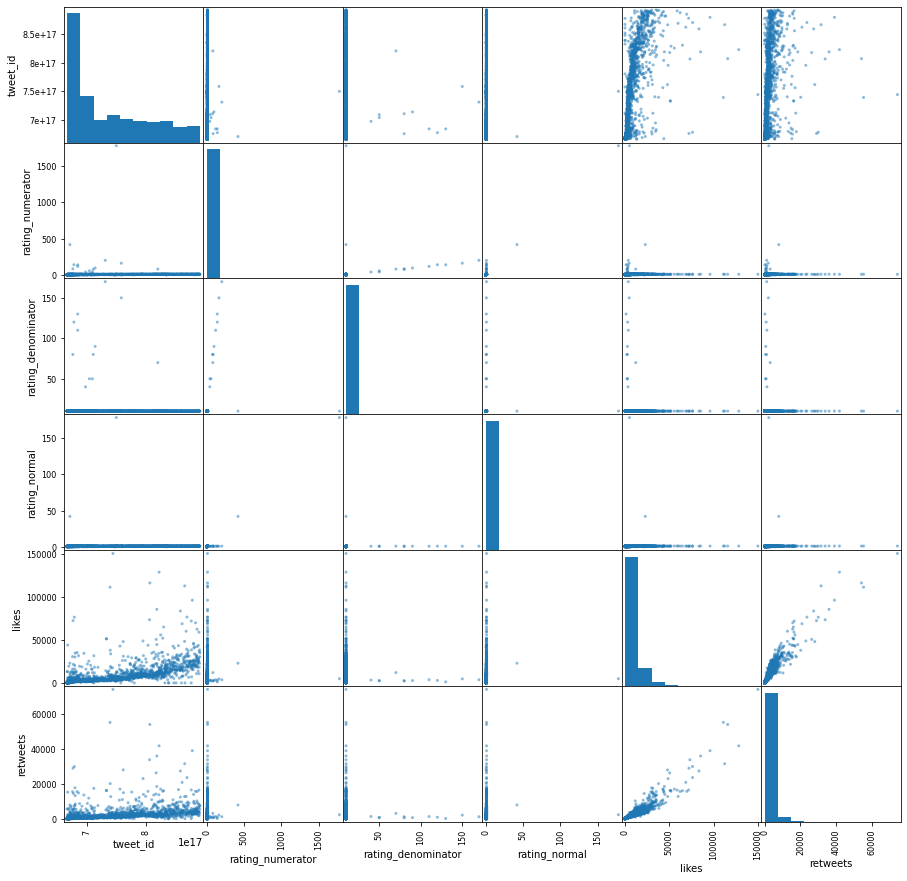

In [112]:
pd.plotting.scatter_matrix(df_dog, figsize=(15,15));

#### First observations:
- There seem to be correlation between number of likes and retweets.
- There are few outliers in ratings - should consider removing them.
- To avoid NA / NaN problems, consider removing those values at least from `likes` and `retweets` or filling with mean (after removing outliers).

In [113]:
# Removing outliers (Snoop Dogg the Outlier: https://twitter.com/dog_rates/status/670842764863651840)
df = df_dog[(np.abs(stats.zscore(df_dog['rating_normal'])) < 3)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 1996
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1995 non-null   int64   
 1   name                1350 non-null   object  
 2   stage               347 non-null    category
 3   rating_numerator    1995 non-null   float64 
 4   rating_denominator  1995 non-null   int64   
 5   rating_normal       1995 non-null   float64 
 6   likes               1986 non-null   Int64   
 7   retweets            1986 non-null   Int64   
dtypes: Int64(2), category(1), float64(2), int64(2), object(1)
memory usage: 130.7+ KB


In [114]:
df.describe()

,tweet_id,rating_numerator,rating_denominator,rating_normal,likes,retweets
count,1.995000e+03,1995.000000,1995.000000,1995.000000,1986.000000,1986.000000
mean,7.365631e+17,11.128962,10.511278,1.055559,7978.003021,2343.436556
std,6.771664e+16,8.569456,7.259293,0.218176,11807.679282,4207.212212
min,6.660209e+17,0.000000,10.000000,0.000000,0.000000,11.000000
25%,6.759938e+17,10.000000,10.000000,1.000000,1666.750000,517.000000
50%,7.092251e+17,11.000000,10.000000,1.100000,3561.000000,1115.500000
75%,7.890232e+17,12.000000,10.000000,1.200000,9889.000000,2671.500000
max,8.924206e+17,204.000000,170.000000,1.500000,150118.000000,74068.000000


**Will fill NaN `likes` and `retweets`** (caused by removed tweets) with their respective means.  
It would seem not the best option, since these means lie far away from the median.  
But as seen below, with the rising popularity of the subject account, their tweets get more attention in general.  
As a consequence, the means for `likes` and `retweets` are getting higher quicker than the medians.

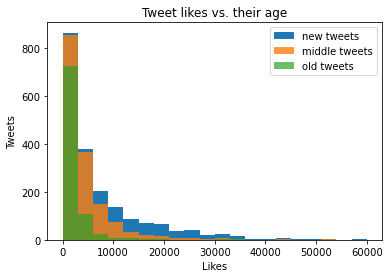

In [115]:
plt.hist(df[(df['tweet_id'] < int(9e17)) & (~df['likes'].isna())]['likes'], alpha=1, bins=20, range=(0, 60000), label='new tweets')
plt.hist(df[(df['tweet_id'] < int(8e17)) & (~df['likes'].isna())]['likes'], alpha=0.8, bins=20, range=(0, 60000), label='middle tweets')
plt.hist(df[(df['tweet_id'] < int(7e17)) & (~df['likes'].isna())]['likes'], alpha=0.7, bins=20, range=(0, 60000), label='old tweets')
plt.legend()
plt.ylabel('Tweets')
plt.xlabel('Likes')
plt.title('Tweet likes vs. their age');

In [116]:
# Filling likes and retweets with their means
df.likes.fillna(int(df.likes.mean()), inplace=True)
df.retweets.fillna(int(df.retweets.mean()), inplace=True)
df = df.astype({'likes':'int64', 'retweets':'int64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 1996
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   tweet_id            1995 non-null   int64   
 1   name                1350 non-null   object  
 2   stage               347 non-null    category
 3   rating_numerator    1995 non-null   float64 
 4   rating_denominator  1995 non-null   int64   
 5   rating_normal       1995 non-null   float64 
 6   likes               1995 non-null   int64   
 7   retweets            1995 non-null   int64   
dtypes: category(1), float64(2), int64(4), object(1)
memory usage: 126.8+ KB


C:\Users\kacpe\anaconda3\lib\site-packages\pandas\core\series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


**Now the below matrix is more useful without outliers and with complete set of numeric data.**

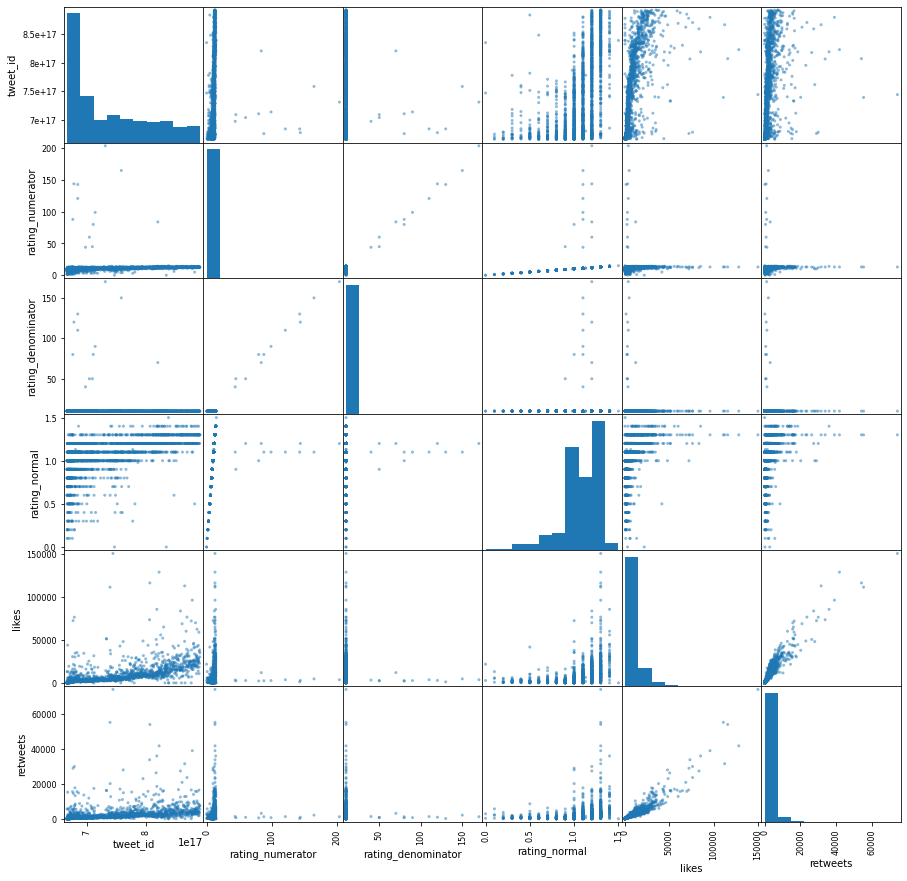

In [117]:
pd.plotting.scatter_matrix(df, figsize=(15,15));

**Zoom on a ratings distribution**

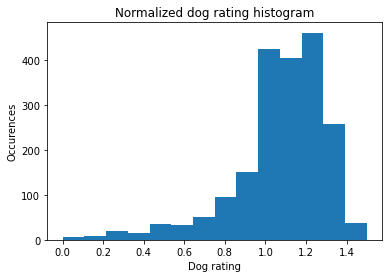

In [118]:
plt.hist(df.rating_normal, bins=14)
plt.title('Normalized dog rating histogram')
plt.xlabel('Dog rating')
plt.ylabel('Occurences');

As seen above, the dog ratings distribution is left-skewed, meaning most dogs get high ratings.

#### Fitting linear regression models to verify correlations

In [119]:
df['intercept'] = 1
lm = sm.OLS(df['retweets'], df[['intercept', 'likes']])
result = lm.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               retweets   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                 1.255e+04
Date:                Tue, 30 Mar 2021   Prob (F-statistic):               0.00
Time:                        14:41:49   Log-Likelihood:                -17491.
No. Observations:                1995   AIC:                         3.499e+04
Df Residuals:                    1993   BIC:                         3.500e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -297.2147     42.037     -7.070      0.000    -379.655    -214.774
likes          0.3310      0.003    112.011      0.000       0.325       0.337
==============================================================================
Omnibus:                     1813.864   Durbin-Watson:                   1.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           250237.239
Skew:                           3.739   Prob(JB):                         0.00
Kurtosis:                      57.355   Cond. No.                     1.72e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Interpretation:
- If a tweet has **no likes**, it will 'likely' have **-297 retweets**, if that was somehow possible.
- From the **correlation coefficient** we can expect that for every **100 likes**, a tweet gathers **33 retweets**.
- **p-value of 0.00** suggests that **likes are statistically significant in relation to retweets**.
- **R-squared value of 0.863** suggests that **86.3% of the variability in retweets can be explained by likes**.

All this said, above points have **verified that likes and retweets are strongly correlated** and therefore **cannot be used along one another in multiple linear regression model** (avoiding multicollinearity).  
#### Below we will fit another model to see how likes depend on assigned dog rating.

In [120]:
lm2 = sm.OLS(df['likes'], df[['intercept', 'rating_normal']])
result2 = lm2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  likes   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     338.4
Date:                Tue, 30 Mar 2021   Prob (F-statistic):           6.17e-70
Time:                        14:41:49   Log-Likelihood:                -21375.
No. Observations:                1995   AIC:                         4.275e+04
Df Residuals:                    1993   BIC:                         4.277e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept     -1.374e+04   1205.382    -11.398      0.000   -1.61e+04   -1.14e+04
rating_normal  2.057e+04   1118.310     18.397      0.000    1.84e+04    2.28e+04
==============================================================================
Omnibus:                     1962.226   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117626.474
Skew:                           4.649   Prob(JB):                         0.00
Kurtosis:                      39.450   Cond. No.                         9.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation:
- If a tweeted dog has **a rating of 0**, it will 'likely' have **-13740 likes**, if that was somehow possible.
- From the **correlation coefficient** we can expect that for every **0.1 increase in rating_normal**, a tweet gathers **2058 likes**.
- **p-value of 0.00** suggests that **likes are statistically significant in relation to dog ratings**.
- However, **R-squared value of 0.145** suggests that only **14.5% of the variability in likes can be explained by dog ratings**.  

#### Dog names and stages popularity

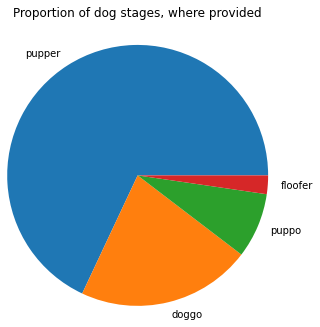

In [123]:
# Plot a pie chart
dft = df[~df['stage'].isna()]
lab = dft.stage.value_counts()
plt.pie(dft.stage.value_counts(), labels=(lab.index), radius=1.5)
plt.title('Proportion of dog stages, where provided', y=1.2);

In [127]:
# Create a list of tuples for bar chart. Names with 4+ occurences in the sample.
name_list = list()
new_tup = tuple()
i = 0
for count in df.name.value_counts() :
    if count > 3 :
        new_tup = (count, df.name.value_counts().index[i])
        name_list.append(new_tup)
        i += 1
    else : break

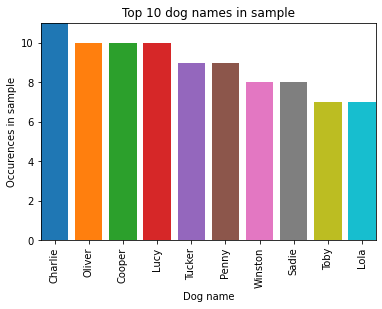

In [128]:
# Plot separate bar for each dog name (top 10 names).
i = 1
ax = plt.subplot(111)
for name in name_list[0:10] :
    ax.bar(i, name[0])
    i += 1
    ax.autoscale(tight=True)
    
plt.xticks(range(1, 11), df.name.value_counts().index[0:10], rotation="vertical")
plt.xlabel("Dog name")
plt.ylabel("Occurences in sample")
plt.title("Top 10 dog names in sample");

### Conclusion
- Dog **ratings distribution is left-skewed**, meaning most dogs get high ratings.
- **Retweets are strongly related to likes** at R-squared of 0.863.
- **Relation of likes to dog ratings is weak** at R-squared of 0.145.
- Above relations are both statistically and practically **significant**.
- Most popular dog names and stages are visible in above plots.

#### Export the notebook to pdf

In [132]:
from subprocess import call
call(['python', '-m', 'nbconvert', '--to', 'pdf', 'wrangle_act.ipynb']);

# Remember to remove API keys!